# Graph Attention Network pour la segmentation de glioblastomes 

## Comment optimiser trouver le bon compromis pour espérer lancer un entraînement sur une petite machine ?

Les moyens que j'ai sont les suivants : 
- Passer de la 3D à de la 2D, ou connecter le graphe principalement de tout en bas sur le volume mais moins entre les slices elles-mêmes
- optimiser SLIC en 3d au lieu de boucler slice par slice 
- optimiser la construction du graphe au lieu de faire une triple boucle sur x y z 

Réduire le nombre de supervoxels n'est pas forcément une bonne idée car on perd vite en précision 

Une autre idée est de faire un sous-échantillonnage spatial -> c'est à dire diviser par 2 la résolution des images par exemple

( je conseil de suivre le tutoriel de pyg d'introduction à pytorch geometric avant de regarder ce code si ce n'est pas fait )

In [35]:
from monai.transforms import (
    Compose, LoadImaged, Lambda, Spacingd, Orientationd,
    ScaleIntensityRanged, CropForegroundd, RandCropByPosNegLabeld,
    ToTensord
)
from monai.data import Dataset, DataLoader
import numpy as np
import os
import glob
from os.path import join
import time
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.color import label2rgb
import pandas as pd
import seaborn as sns # c'est plus beau que matplotlib en vrai les graphiques seaborn 👀

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from joblib import Parallel, delayed
from functools import partial

import networkx as nx
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data

from collections import defaultdict

from torch_geometric.loader import DataLoader as PyGDataLoader


import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv


import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

In [3]:
# une classe pour définir les transformations personnalisées
class ToTensor:
    def __call__(self, sample):
        try:
            image, label = sample['image'], sample['label']
            #print("Transformation ToTensor: Transposition des dimensions de l'image.")
            if image.ndim != 4:
                raise ValueError(f"L'image doit avoir 4 dimensions (H, W, D, C). Dimensions actuelles: {image.shape}")
            image = image.transpose((3, 0, 1, 2))  # (C, H, W, D)
            label = label.astype(np.int64)
            #print(f"Transformation ToTensor: Conversion en tenseurs. Image shape: {image.shape}, Label shape: {label.shape}")
            return {
                'image': torch.from_numpy(image).float(),
                'label': torch.from_numpy(label)
            }
        except Exception as e:
            print(f"Erreur dans ToTensor: {e}")
            raise e

class NormalizeRobust:
    def __call__(self, sample):
        try:
            image, label = sample['image'], sample['label']
            #print("Transformation NormalizeRobust: Normalisation des canaux.")
            for c in range(image.shape[0]):
                channel = image[c]
                lower_bound = np.percentile(channel, 0.1)
                upper_bound = np.percentile(channel, 99.9)
                #print(f"Canal {c}: Clip entre {lower_bound} et {upper_bound}.")
                channel = np.clip(channel, lower_bound, upper_bound)
                mean = channel.mean()
                std = channel.std()
                if std != 0:
                    image[c] = (channel - mean) / std
                    #print(f"Canal {c}: Normalisation avec mean={mean:.4f}, std={std:.4f}.")
                else:
                    image[c] = channel - mean
                    #print(f"Canal {c}: Normalisation sans std (std=0).")
                # Vérifications supplémentaires
                if np.isnan(image[c]).any():
                    raise ValueError(f"NaN détecté dans le canal {c} après normalisation.")
                if np.isinf(image[c]).any():
                    raise ValueError(f"Infini détecté dans le canal {c} après normalisation.")
            return {'image': image, 'label': label}
        except Exception as e:
            print(f"Erreur dans NormalizeRobust: {e}")
            raise e

# Mon data loader 
class BraTS2021Dataset(Dataset):
    def __init__(self, data_root, case_names, transform=None):
        super(BraTS2021Dataset, self).__init__()
        self.data_root = data_root
        self.case_names = case_names
        self.transform = transform
        #print(f"Initialisation du Dataset: {len(self.case_names)} cas chargés.")

    def __len__(self):
        return len(self.case_names)

    def __getitem__(self, idx):
        try:
            name = self.case_names[idx]
            base_dir = join(self.data_root, name, name)
            #print(f"Chargement du cas {idx + 1}/{len(self.case_names)}: {name}")
            
            flair_path = base_dir + '_flair.nii.gz'
            t1_path = base_dir + '_t1.nii.gz'
            t1ce_path = base_dir + '_t1ce.nii.gz'
            t2_path = base_dir + '_t2.nii.gz'
            seg_path = base_dir + '_seg.nii.gz'
            
            for path in [flair_path, t1_path, t1ce_path, t2_path, seg_path]:
                if not os.path.exists(path):
                    raise FileNotFoundError(f"Fichier manquant: {path}")
                else:
                    #print(f"Fichier trouvé: {path}")
                    pass
            
            flair = nib.load(flair_path).get_fdata()
            t1 = nib.load(t1_path).get_fdata()
            t1ce = nib.load(t1ce_path).get_fdata()
            t2 = nib.load(t2_path).get_fdata()
            mask = nib.load(seg_path).get_fdata()
            #print(f"Chargement réussi des fichiers pour le cas {name}.")
            
            if flair.shape != t1.shape or flair.shape != t1ce.shape or flair.shape != t2.shape:
                raise ValueError(f"Dimensions incohérentes pour le cas {name}: "
                                 f"FLAIR {flair.shape}, T1 {t1.shape}, T1ce {t1ce.shape}, T2 {t2.shape}")
            print(f"Dimensions vérifiées pour le cas {name}: {flair.shape}")
            
            # Empiler les modalités en un seul array avec 4 canaux
            image = np.stack([flair, t1, t1ce, t2], axis=-1)  # Shape: (H, W, D, C)
            #print(f"Empilement des modalités: Image shape après empilement: {image.shape}")
            
            sample = {'image': image, 'label': mask}
            
            if self.transform:
                #print("Application des transformations.")
                sample = self.transform(sample)
            else:
                print("Aucune transformation appliquée.")
            
            #print(f"Retour de l'échantillon {idx + 1}: Image shape: {sample['image'].shape}, Label shape: {sample['label'].shape}")
            return sample['image'], sample['label']
        
        except Exception as e:
            print(f"Erreur lors de l'accès à l'échantillon {idx}: {e}")
            raise e

# pour obtenir les noms des cas
def get_case_names(data_root, mode='train'):
    try:
        all_cases = sorted(os.listdir(data_root))
        print(f"Total des cas disponibles dans {data_root}: {len(all_cases)}")
        if mode == 'train':
            selected_cases = all_cases[:int(0.8 * len(all_cases))]
            print(f"Mode: {mode}, Cas sélectionnés pour l'entraînement: {len(selected_cases)}")
            return selected_cases
        elif mode == 'val':
            selected_cases = all_cases[int(0.8 * len(all_cases)):int(0.9 * len(all_cases))]
            print(f"Mode: {mode}, Cas sélectionnés pour la validation: {len(selected_cases)}")
            return selected_cases
        elif mode == 'test':
            selected_cases = all_cases[int(0.9 * len(all_cases)):]
            print(f"Mode: {mode}, Cas sélectionnés pour le test: {len(selected_cases)}")
            return selected_cases
        else:
            raise ValueError("Mode doit être 'train', 'val' ou 'test'.")
    except Exception as e:
        print(f"Erreur dans get_case_names: {e}")
        raise e

data_root = '/Volumes/DockUSBStockage/Datasets/brats2021/BraTS2021_Training_Data'

if not os.path.exists(data_root):
    raise FileNotFoundError(f"Le répertoire des données n'existe pas: {data_root}")
else:
    #print(f"Répertoire des données trouvé: {data_root}")
    pass

train_cases = get_case_names(data_root, mode='train')
val_cases = get_case_names(data_root, mode='val')
test_cases = get_case_names(data_root, mode='test')

train_transforms = transforms.Compose([
    ToTensor(),
    NormalizeRobust(),
])

infer_transforms = transforms.Compose([
    ToTensor(),
    NormalizeRobust(),
])

try:
    print("Création du dataset d'entraînement.")
    train_dataset = BraTS2021Dataset(data_root=data_root, case_names=train_cases, transform=train_transforms)
    print("Création du dataset de validation.")
    val_dataset = BraTS2021Dataset(data_root=data_root, case_names=val_cases, transform=infer_transforms)
    print("Création du dataset de test.")
    test_dataset = BraTS2021Dataset(data_root=data_root, case_names=test_cases, transform=infer_transforms)
except Exception as e:
    print(f"Erreur lors de la création des datasets: {e}")
    raise e

try:
    print("Création du DataLoader d'entraînement avec num_workers=0 pour le débogage.")
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)
    print("Création du DataLoader de validation avec num_workers=0 pour le débogage.")
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)
    print("Création du DataLoader de test avec num_workers=0 pour le débogage.")
    test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)
except Exception as e:
    print(f"Erreur lors de la création des DataLoaders: {e}")
    raise e

def visualize_sample(image, label, slice_idx=30):
    try:
        #print(f"Visualisation de l'échantillon: slice index = {slice_idx}")
        modalities = ['FLAIR', 'T1', 'T1ce', 'T2']
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        for c in range(4):
            #print(f"Affichage du canal {c}: {modalities[c]}")
            axes[0, c].imshow(image[c, :, :, slice_idx], cmap='gray')
            axes[0, c].set_title(f"{modalities[c]} Slice {slice_idx}")
            axes[0, c].axis('off')
        #print("Affichage du masque de segmentation.")
        axes[1, 0].imshow(label[:, :, slice_idx], cmap='gray')
        axes[1, 0].set_title(f"Label Slice {slice_idx}")
        axes[1, 0].axis('off')
        for c in range(1, 4):
            axes[1, c].axis('off')
        plt.show()
        #print("Visualisation terminée.")
    except Exception as e:
        #print(f"Erreur lors de la visualisation de l'échantillon: {e}")
        raise e

Total des cas disponibles dans /Volumes/DockUSBStockage/Datasets/brats2021/BraTS2021_Training_Data: 1252
Mode: train, Cas sélectionnés pour l'entraînement: 1001
Total des cas disponibles dans /Volumes/DockUSBStockage/Datasets/brats2021/BraTS2021_Training_Data: 1252
Mode: val, Cas sélectionnés pour la validation: 125
Total des cas disponibles dans /Volumes/DockUSBStockage/Datasets/brats2021/BraTS2021_Training_Data: 1252
Mode: test, Cas sélectionnés pour le test: 126
Création du dataset d'entraînement.
Création du dataset de validation.
Création du dataset de test.
Création du DataLoader d'entraînement avec num_workers=0 pour le débogage.
Création du DataLoader de validation avec num_workers=0 pour le débogage.
Création du DataLoader de test avec num_workers=0 pour le débogage.


afficher la slice 30 pour test sur un patient 

Dimensions vérifiées pour le cas BraTS2021_00375: (240, 240, 155)
Dimensions vérifiées pour le cas BraTS2021_01103: (240, 240, 155)
Batch loaded: Images shape: torch.Size([2, 4, 240, 240, 155]), Labels shape: torch.Size([2, 240, 240, 155])


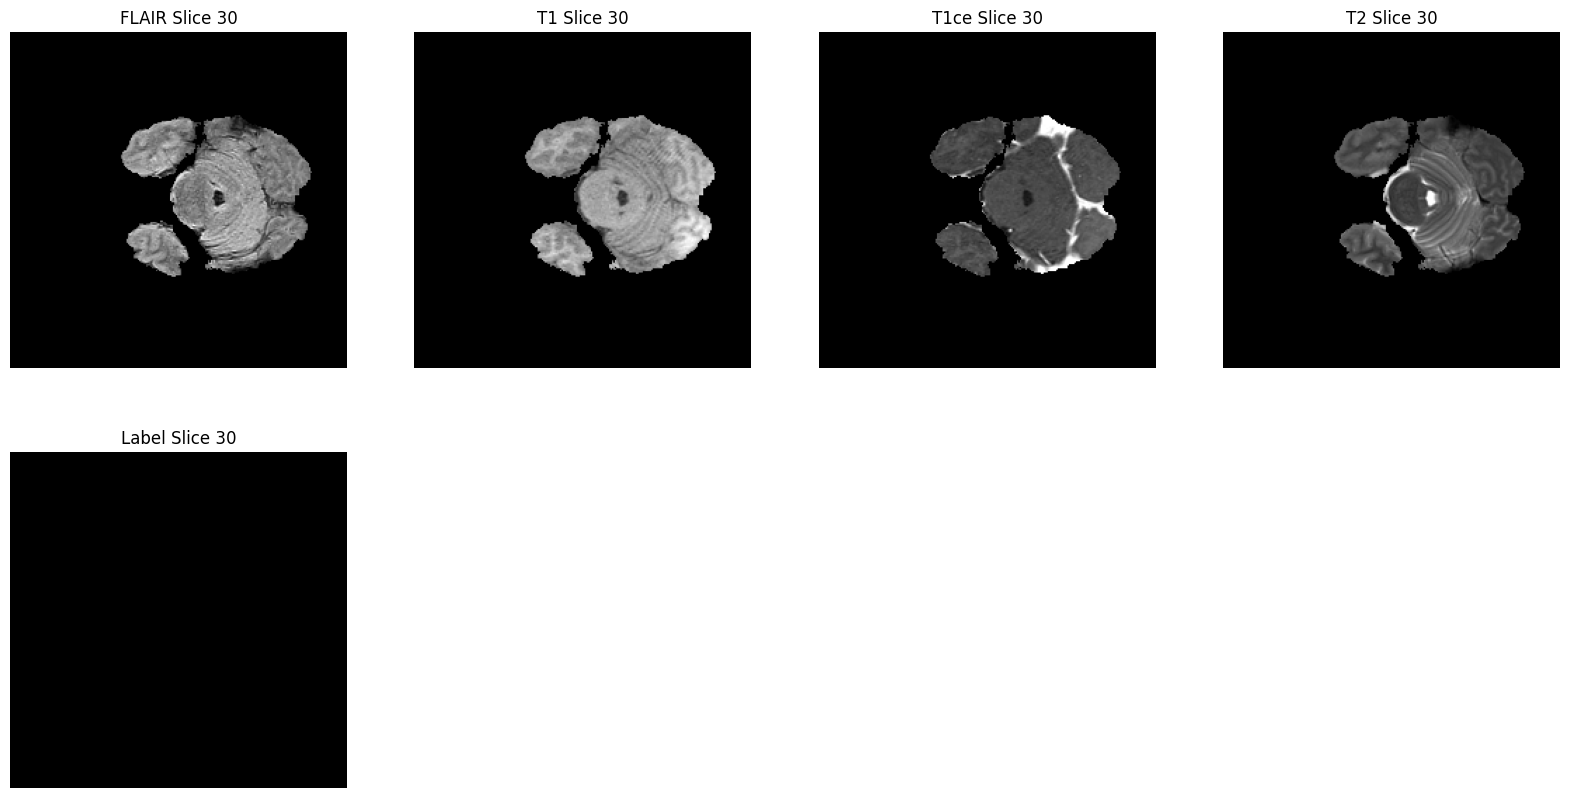

In [25]:
try:
    #print("Chargement du premier batch du DataLoader d'entraînement.")
    images, labels = next(iter(train_loader))
    print(f"Batch loaded: Images shape: {images.shape}, Labels shape: {labels.shape}")
    #print("Visualisation du premier échantillon du batch.")
    visualize_sample(images[0].numpy(), labels[0].numpy())
except Exception as e:
    print(f"Erreur lors du chargement ou de la visualisation du batch: {e}")
    raise e

240 : height
240 : width
155 : depth (nb de voxels de profondeur)
4 : 4 modalités d'images différentes
2 : batch size -> nb d'éléments dans le batch 

Chargement du premier batch du DataLoader d'entraînement.
Dimensions vérifiées pour le cas BraTS2021_01261: (240, 240, 155)
Dimensions vérifiées pour le cas BraTS2021_01315: (240, 240, 155)
Batch loaded: Images shape: torch.Size([2, 4, 240, 240, 155]), Labels shape: torch.Size([2, 240, 240, 155])
Visualisation de l'échantillon 0 du batch.
Nombre de slices avec un masque: 50


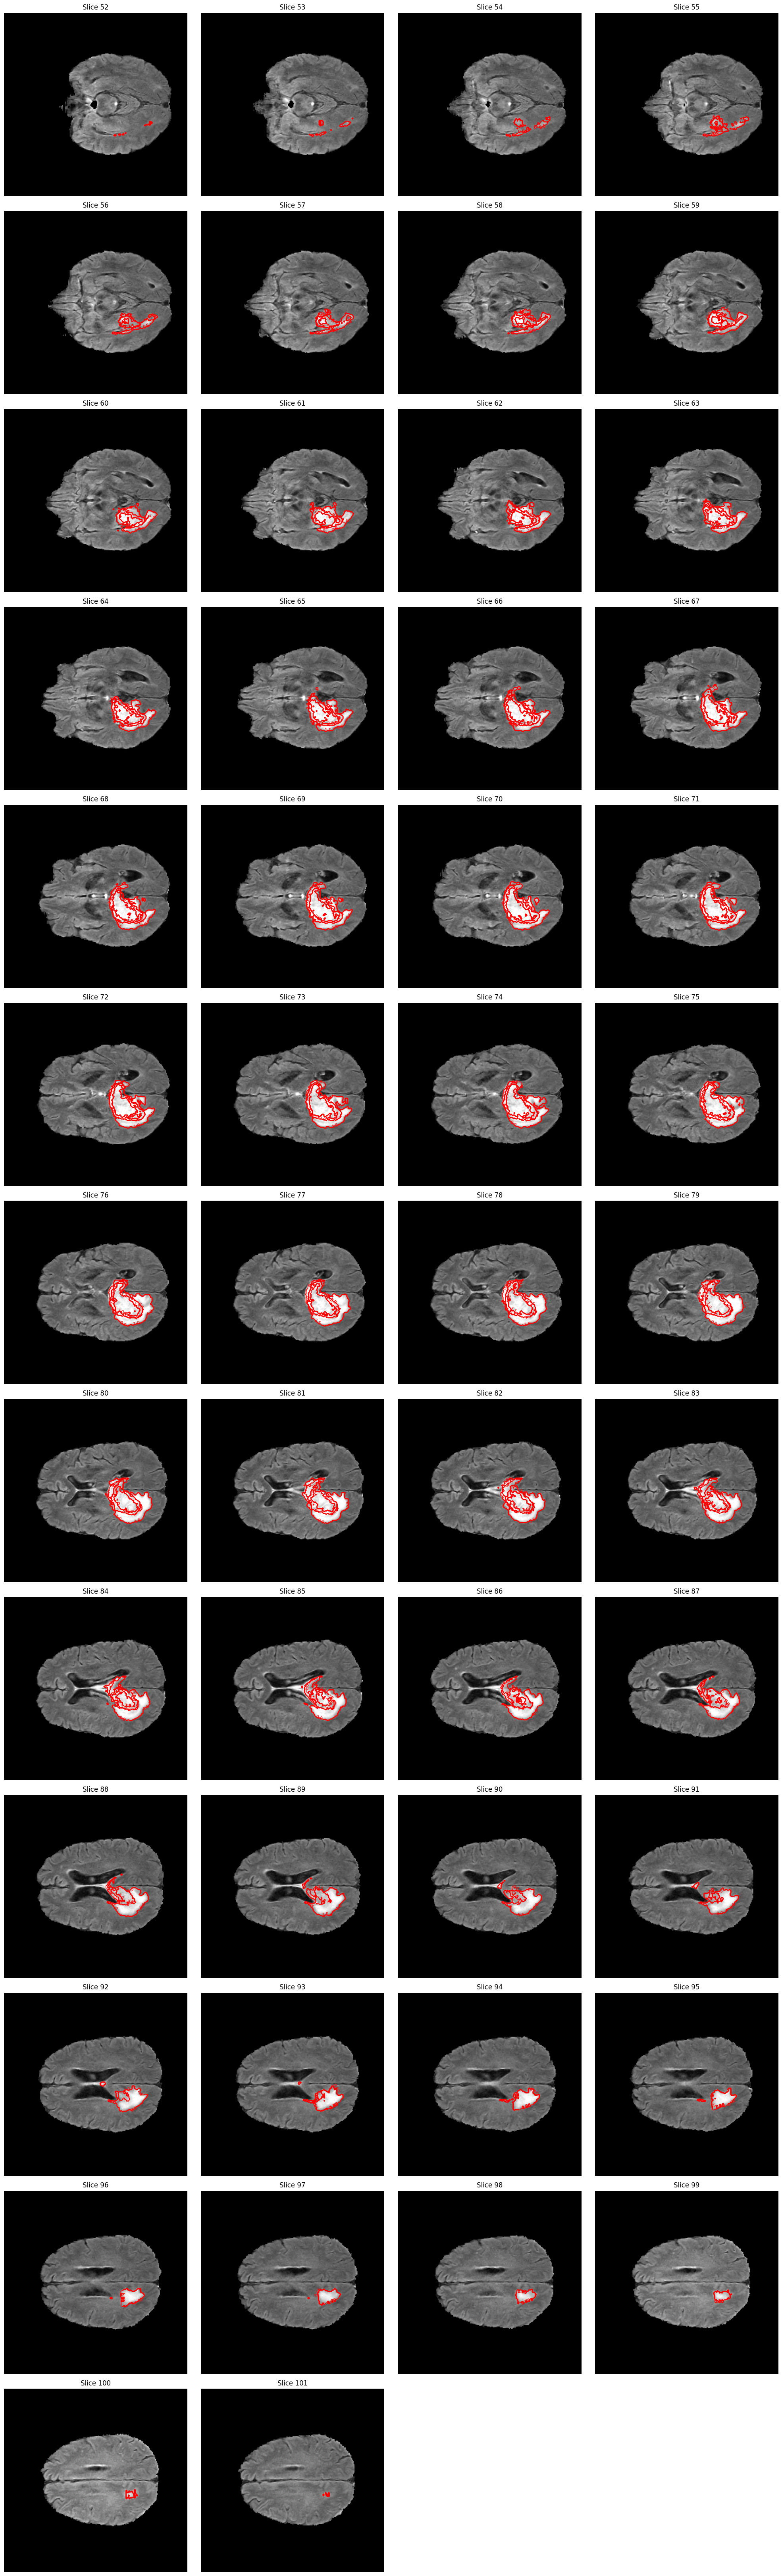

In [26]:
def get_slices_with_mask(label):
    """
    Retourne les indices des slices où le masque contient au moins un voxel marqué.
    
    Args:
        label (numpy.ndarray): Masque 3D de forme (H, W, D)
        
    Returns:
        list: Liste des indices des slices avec un masque
    """
    slices = []
    D = label.shape[2]
    for slice_idx in range(D):
        if np.any(label[:, :, slice_idx] > 0):
            slices.append(slice_idx)
    return slices

def visualize_slices_with_mask(image, label, slices=None, modality_idx=0):
    """
    Affiche les slices spécifiées avec les contours du masque superposés.
    
    Args:
        image (numpy.ndarray): Image 4D de forme (C, H, W, D)
        label (numpy.ndarray): Masque 3D de forme (H, W, D)
        slices (list, optional): Liste des indices des slices à afficher. Si None, toutes les slices avec masque sont affichées.
        modality_idx (int, optional): Indice de la modalité à afficher (par défaut 0 pour FLAIR)
    """
    if slices is None:
        slices = get_slices_with_mask(label)
    
    num_slices = len(slices)
    if num_slices == 0:
        print("Aucune slice avec un masque trouvé.")
        return
    
    # Définir le nombre de colonnes pour la grille de visualisation
    cols = 4
    rows = num_slices // cols + int(num_slices % cols != 0)
    
    fig, axs = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    axs = axs.flatten()  # Aplatir la grille pour une itération facile
    
    for i, slice_idx in enumerate(slices):
        if i >= len(axs):
            break  # Éviter de dépasser le nombre d'axes disponibles
        ax = axs[i]
        ax.imshow(image[modality_idx, :, :, slice_idx], cmap='gray')
        # Ajouter les contours du label
        contours = ax.contour(label[:, :, slice_idx], colors='r', linewidths=1)
        ax.clabel(contours, inline=True, fontsize=8)
        ax.set_title(f"Slice {slice_idx}")
        ax.axis('off')
    
    # pr delete les axes inutilisés si le nombre de slices n'est pas un multiple de cols
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()

try:
    print("Chargement du premier batch du DataLoader d'entraînement.")
    images, labels = next(iter(train_loader))
    print(f"Batch loaded: Images shape: {images.shape}, Labels shape: {labels.shape}")
    
    # le premier du batch
    sample_idx = 0
    print(f"Visualisation de l'échantillon {sample_idx} du batch.")
    
    image = images[sample_idx].numpy()  # Shape: (C, H, W, D)
    label = labels[sample_idx].numpy()  # Shape: (H, W, D)
    
    # identifier les slices avec un masque
    slices_with_mask = get_slices_with_mask(label)
    print(f"Nombre de slices avec un masque: {len(slices_with_mask)}")
    
    visualize_slices_with_mask(image, label, slices=slices_with_mask, modality_idx=0)  # modality_idx=0 pour FLAIR
    
except Exception as e:
    print(f"Erreur lors du chargement ou de la visualisation du batch: {e}")
    raise e

In [7]:
def apply_slic_3d(image, n_segments=100, compactness=10, sigma=1):
    """
    Applique SLIC sur chaque coupe du volume 3D.

    Args:
        image (numpy.ndarray): Image 4D de forme (C, H, W, D)
        n_segments (int): Nombre de segments superpixels par coupe
        compactness (float): Compacité des superpixels
        sigma (float): Écart type du filtre gaussien

    Returns:
        numpy.ndarray: Superpixels 3D de forme (H, W, D)
    """
    start_time = time.time()  
    C, H, W, D = image.shape
    superpixels = np.zeros((H, W, D), dtype=np.int32)

    #print(f"Applying SLIC to each of {D} slices.")

    for d in range(D):
        loop_start = time.time()
        # Extraire la coupe actuelle en fixant l'axe D
        slice_img = image[:, :, :, d].mean(axis=0)  # Shape: (H, W)

        #print(f"Slice {d}: slice_img shape: {slice_img.shape}")

        # Appliquer SLIC avec channel_axis=None pour les images grayscale
        segments = slic(
            slice_img,
            n_segments=n_segments,
            compactness=compactness,
            sigma=sigma,
            start_label=1,
            channel_axis=None  # Indique que l'image est en niveaux de gris
        )

        #print(f"Slice {d}: segments shape: {segments.shape}")

        # Vérifier si la forme correspond
        if segments.shape != (H, W):
            print(f"Warning: Segment shape {segments.shape} does not match expected shape ({H}, {W}) for slice {d}.")

        # Stocker les segments avec un décalage pour éviter les chevauchements entre coupes
        try:
            superpixels[:, :, d] = segments + d * n_segments
        except ValueError as e:
            print(f"Error assigning segments to superpixels for slice {d}: {e}")
            print(f"Expected shape: {(H, W)}, but got: {segments.shape}")
            raise e
        loop_end = time.time()
        print(f"coupe {d} terminée en {loop_end - loop_start:.2f} secondes")

    total_time = time.time() - start_time
    print(f"temps total pour apply_slic_3d: {total_time:.2f} secondes")
    return superpixels

images, labels = next(iter(train_loader))
image = images[0].numpy()  # Shape: (C, H, W, D)
label = labels[0].numpy()  # Shape: (H, W, D)

print(f"Image shape: {image.shape}")  # Doit être (C, H, W, D)
print(f"Label shape: {label.shape}")  # Doit être (H, W, D)

# appliquer SLIC en 3D avec la fonction corrigée
superpixels = apply_slic_3d(image, n_segments=50, compactness=0.1, sigma=0.1)
print(f"Superpixels shape: {superpixels.shape}")  # Doit être (H, W, D)

Dimensions vérifiées pour le cas BraTS2021_00730: (240, 240, 155)
Dimensions vérifiées pour le cas BraTS2021_01345: (240, 240, 155)
Image shape: (4, 240, 240, 155)
Label shape: (240, 240, 155)
coupe 0 terminée en 0.03 secondes
coupe 1 terminée en 0.02 secondes
coupe 2 terminée en 0.02 secondes
coupe 3 terminée en 0.04 secondes
coupe 4 terminée en 0.01 secondes
coupe 5 terminée en 0.01 secondes
coupe 6 terminée en 0.01 secondes
coupe 7 terminée en 0.01 secondes
coupe 8 terminée en 0.02 secondes
coupe 9 terminée en 0.02 secondes
coupe 10 terminée en 0.02 secondes
coupe 11 terminée en 0.02 secondes
coupe 12 terminée en 0.02 secondes
coupe 13 terminée en 0.01 secondes
coupe 14 terminée en 0.01 secondes
coupe 15 terminée en 0.01 secondes
coupe 16 terminée en 0.01 secondes
coupe 17 terminée en 0.01 secondes
coupe 18 terminée en 0.01 secondes
coupe 19 terminée en 0.01 secondes
coupe 20 terminée en 0.01 secondes
coupe 21 terminée en 0.01 secondes
coupe 22 terminée en 0.01 secondes
coupe 23 ter

le probleme c'est que si je mets trop de superpixels, ca va faire trop de noeuds dans le graphes et cv exploser computationnallement

In [107]:
# pour identifier les superpixels dans le masque (sur le masque)
def get_superpixels_in_mask(superpixels, mask):
    """
    Identifie les superpixels qui chevauchent le masque.
    
    Args:
        superpixels (numpy.ndarray): Superpixels 3D de forme (H, W, D)
        mask (numpy.ndarray): Masque 3D de forme (H, W, D)
    
    Returns:
        set: Ensemble des labels de superpixels qui chevauchent le masque
    """
    superpixels_in_mask = superpixels[mask > 0]
    unique_superpixels = np.unique(superpixels_in_mask)
    return set(unique_superpixels)

# identifier les superpixels dans le masque
superpixels_in_mask = get_superpixels_in_mask(superpixels, label)
print(f"Nombre de superpixels dans le masque: {len(superpixels_in_mask)}")

Nombre de superpixels dans le masque: 65


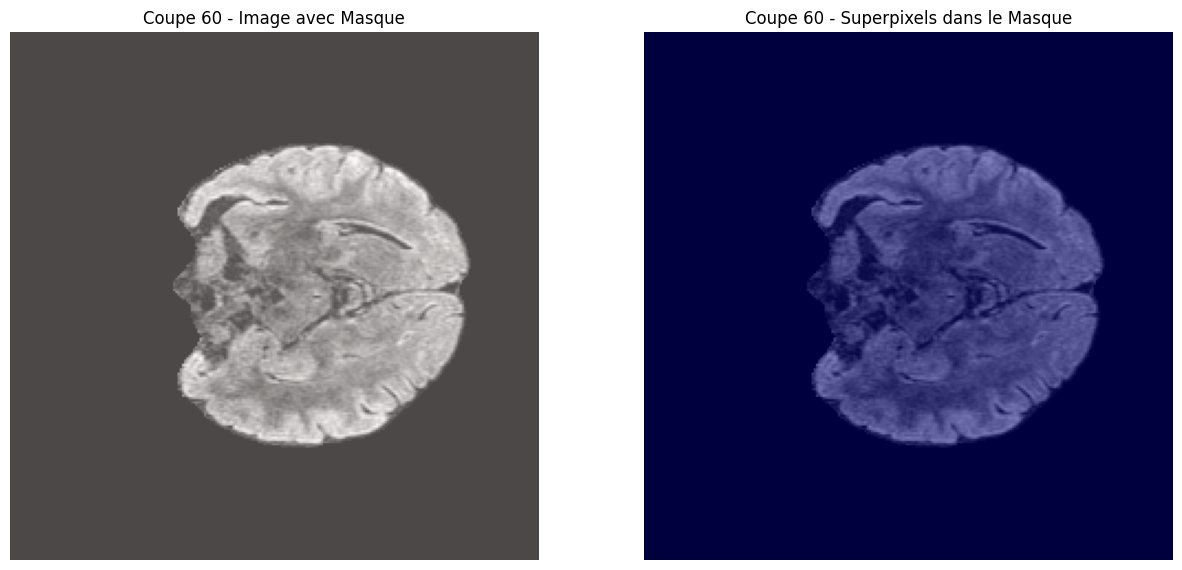

In [24]:
def visualize_superpixels_in_mask(image, mask, superpixels, superpixels_in_mask, slice_idx=30, modality_idx=0):
    """
    Visualise une coupe avec les superpixels du masque superposés.
    
    Args:
        image (numpy.ndarray): Image 4D de forme (C, H, W, D)
        mask (numpy.ndarray): Masque 3D de forme (H, W, D)
        superpixels (numpy.ndarray): Superpixels 3D de forme (H, W, D)
        superpixels_in_mask (set): Ensemble des superpixels dans le masque
        slice_idx (int): Indice de la coupe à visualiser
        modality_idx (int): Indice de la modalité à visualiser
    """
    C, H, W, D = image.shape
    img_slice = image[modality_idx, :, :, slice_idx]
    mask_slice = mask[:, :, slice_idx]
    superpixel_slice = superpixels[:, :, slice_idx]
    
    # Créer un masque des superpixels à mettre en évidence
    highlight_mask = np.isin(superpixel_slice, list(superpixels_in_mask))
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    
    # Afficher l'image avec le masque
    ax[0].imshow(img_slice, cmap='gray')
    ax[0].imshow(mask_slice, cmap='Reds', alpha=0.3)
    ax[0].set_title(f"Coupe {slice_idx} - Image avec Masque")
    ax[0].axis('off')
    
    # Afficher l'image avec les superpixels sélectionnés
    ax[1].imshow(img_slice, cmap='gray')
    ax[1].imshow(highlight_mask, cmap='jet', alpha=0.5)
    ax[1].set_title(f"Coupe {slice_idx} - Superpixels dans le Masque")
    ax[1].axis('off')
    
    plt.show()

visualize_superpixels_in_mask(image, label, superpixels, superpixels_in_mask, slice_idx=60, modality_idx=0)

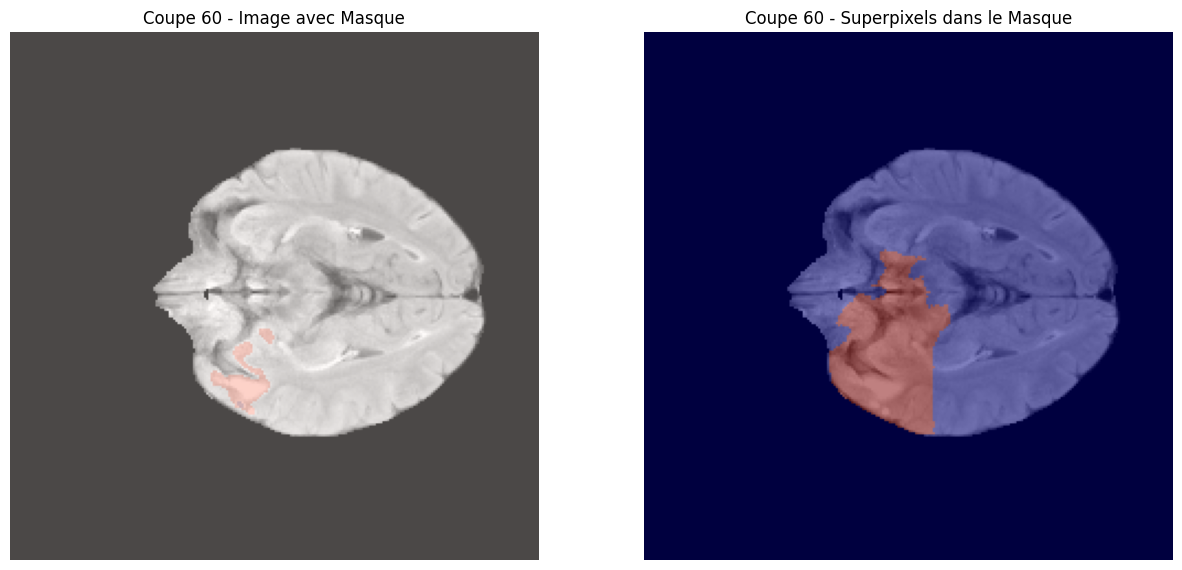

In [108]:
def visualize_superpixels_in_mask(image, mask, superpixels, superpixels_in_mask, slice_idx=30, modality_idx=0):
    """
    Visualise une coupe avec les superpixels du masque superposés.
    
    Args:
        image (numpy.ndarray): Image 4D de forme (C, H, W, D)
        mask (numpy.ndarray): Masque 3D de forme (H, W, D)
        superpixels (numpy.ndarray): Superpixels 3D de forme (H, W, D)
        superpixels_in_mask (set): Ensemble des superpixels dans le masque
        slice_idx (int): Indice de la coupe à visualiser
        modality_idx (int): Indice de la modalité à visualiser
    """
    C, H, W, D = image.shape
    img_slice = image[modality_idx, :, :, slice_idx]
    mask_slice = mask[:, :, slice_idx]
    superpixel_slice = superpixels[:, :, slice_idx]
    
    # Créer un masque des superpixels à mettre en évidence
    highlight_mask = np.isin(superpixel_slice, list(superpixels_in_mask))
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    
    # Afficher l'image avec le masque
    ax[0].imshow(img_slice, cmap='gray')
    ax[0].imshow(mask_slice, cmap='Reds', alpha=0.3)
    ax[0].set_title(f"Coupe {slice_idx} - Image avec Masque")
    ax[0].axis('off')
    
    # Afficher l'image avec les superpixels sélectionnés
    ax[1].imshow(img_slice, cmap='gray')
    ax[1].imshow(highlight_mask, cmap='jet', alpha=0.5)
    ax[1].set_title(f"Coupe {slice_idx} - Superpixels dans le Masque")
    ax[1].axis('off')
    
    plt.show()

visualize_superpixels_in_mask(image, label, superpixels, superpixels_in_mask, slice_idx=60, modality_idx=0)

In [109]:
# le probleme c'est que j'applique ça sur chaque superpixel donc ça peut prendre un temps fou si y en a 10 000 par exemple 
def process_superpixel(sp_id, images, mask, percentiles):
    """
    Traite un seul superpixel pour calculer ses caractéristiques et son label.

    Args:
        sp_id (int): ID du superpixel.
        images (numpy.ndarray): Images IRM (C, H, W, D).
        mask (numpy.ndarray): Masque de tumeur (H, W, D).
        percentiles (list of int): Liste des percentiles à calculer.

    Returns:
        tuple or None: (caractéristiques, label) ou None si superpixel invalide.
    """
    #start_time_total = time.time()

    #t1 = time.time()
    sp_mask = superpixels == sp_id
    #t2 = time.time()
    #print(f"temps creation masque sp_id={sp_id} : {t2 - t1:.4f} s")
    #t3 = time.time()
    if not np.any(images[:, sp_mask]):
        #t4 = time.time()
        #print(f"superpixel {sp_id} invalide : intensités nulles, temps verif intensites : {t4 - t3:.4f} s")
        #print(f"temps total process_superpixel(sp_id={sp_id}) : {time.time() - start_time_total:.4f} s")
        return None  # Superpixel invalide (intensités nulles dans toutes les modalités)
    #t4 = time.time()
    #print(f"superpixel {sp_id} valide : intensités non nulles, temps verif intensites : {t4 - t3:.4f} s")

    #t5 = time.time()
    label = 1 if np.any(mask[sp_mask]) else 0
    #t6 = time.time()
    #print(f"temps calcul label sp_id={sp_id} : {t6 - t5:.4f} s")

    #t7 = time.time()
    sp_features = []
    for c in range(images.shape[0]):
        intensities = images[c, sp_mask]
        sp_percentiles = np.percentile(intensities, percentiles)
        sp_features.extend(sp_percentiles)
    #t8 = time.time()
    #print(f"temps boucle calcul percentiles sp_id={sp_id} : {t8 - t7:.4f} s")

    #total_time = time.time() - start_time_total
    #print(f"temps total process_superpixel(sp_id={sp_id}) : {total_time:.4f} s")
    #print()
    #print()
    #print()
    return (sp_features, label)

def extract_node_features_parallel(images, superpixels, mask, percentiles=[10, 25, 50, 75, 90], n_jobs=-1):
    """
    Extrait des caractéristiques pour chaque superpixel en parallèle.

    Args:
        images (numpy.ndarray): Image IRM 4D (C, H, W, D).
        superpixels (numpy.ndarray): Superpixels 3D (H, W, D).
        mask (numpy.ndarray): Masque de tumeur 3D (H, W, D).
        percentiles (list of int): Liste des percentiles à calculer.
        n_jobs (int): Nombre de jobs parallèles (-1 pour tous les cores).

    Returns:
        torch.Tensor: Tensor des caractéristiques (num_superpixels_valides, C * len(percentiles)).
        torch.Tensor: Tensor des labels (num_superpixels_valides,).
    """
    start_time_total = time.time()  
    C, H, W, D = images.shape
    unique_superpixels = np.unique(superpixels)
    print(f"Nombre de superpixels uniques: {len(unique_superpixels)}")
    
    # Définir une fonction partielle avec les arguments fixes sauf sp_id
    define_func_time_start = time.time()
    func = partial(process_superpixel, images=images, mask=mask, percentiles=percentiles)
    define_func_time_end = time.time()
    print(f"temps pour définir la fonction partielle : {define_func_time_end - define_func_time_start:.2f} s")

    # Joblib pour paralléliser le traitement  
    # pour chaque super pixel, on va va executer la fonction process_superpixel  
    joblib_time_start = time.time()
    results = Parallel(n_jobs=n_jobs, verbose=10)(delayed(func)(sp_id) for sp_id in unique_superpixels)
    joblib_time_end = time.time()
    print(f"temps pour la partie parallelisation : {joblib_time_end - joblib_time_start:.2f} s")
    
    # filtrer les résultats invalides
    filter_time_start = time.time()
    results = [res for res in results if res is not None]
    filter_time_end = time.time()
    print(f"temps pour filtrer les résultats invalides : {filter_time_end - filter_time_start:.2f} s")
    
    if not results:
        total_time = time.time() - start_time_total
        print(f"aucun superpixel valide, temps total: {total_time:.2f} s")
        return torch.empty(0, len(percentiles)*C), torch.empty(0, dtype=torch.long)
    
    stack_time_start = time.time()
    features, labels = zip(*results)
    
    features_tensor = torch.tensor(features, dtype=torch.float)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    stack_time_end = time.time()
    print(f"temps pour créer les tenseurs pytorch : {stack_time_end - stack_time_start:.2f} s")
    
    total_time = time.time() - start_time_total
    print(f"temps total pour extract_node_features_parallel : {total_time:.2f} s")
    return features_tensor, labels_tensor

# extraire les caractéristiques et les labels des noeuds
features, node_labels = extract_node_features_parallel(image, superpixels, label)

print(f"Shape des features: {features.shape}")  # (num_superpixels_valides, C * len(percentiles)) ?
print(f"Shape des labels: {node_labels.shape}")  # (num_superpixels_valides,) ?

Nombre de superpixels uniques: 6754


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Shape des features: torch.Size([6754, 20])
Shape des labels: torch.Size([6754])


[Parallel(n_jobs=-1)]: Done 6754 out of 6754 | elapsed:  1.9min finished


## version optimisée :

In [12]:
def get_bounding_box_3d(mask):
    """
    renvoie (ymin, ymax, xmin, xmax, zmin, zmax) pour rogner la zone contenant la tumeur
    suppose que mask est de taille (h, w, d).
    """
    # indices des voxels non nuls
    coords = np.argwhere(mask > 0)
    if coords.size == 0:
        # pas de voxels non nuls => pas de bounding box (on retourne tout)
        return (0, mask.shape[0], 0, mask.shape[1], 0, mask.shape[2])
    
    ymin, xmin, zmin = coords.min(axis=0)
    ymax, xmax, zmax = coords.max(axis=0)
    # pour inclure la frontière max, on fait +1
    return (ymin, ymax+1, xmin, xmax+1, zmin, zmax+1)

def build_superpixel_voxel_map(superpixels):
    """
    construit un dictionnaire: sp_id -> liste de (y, x, z) appartenant à ce superpixel.
    superpixels : (h, w, d)
    """
    sp_index_map = defaultdict(list)
    h, w, d = superpixels.shape
    for z in range(d):
        for y in range(h):
            for x in range(w):
                sp = superpixels[y, x, z]
                sp_index_map[sp].append((y, x, z))
    return sp_index_map


def process_superpixels_batch(sp_ids, sp_index_map, images, mask, percentiles):
    """
    traite un *lot* de superpixels pour calculer leurs caractéristiques, 
    et renvoie une liste [(features, label), ...].
    """
    batch_results = []
    c = images.shape[0]

    for sp_id in sp_ids:
        # récupération des indices du superpixel sp_id (déjà vectorisé)
        voxel_coords = sp_index_map[sp_id]  # liste de (y, x, z)

        if not voxel_coords:  # superpixel vide
            batch_results.append(None)
            continue

        # on convertit la liste en array pour indexer plus facilement
        voxel_coords_arr = np.array(voxel_coords)
        ys = voxel_coords_arr[:, 0]
        xs = voxel_coords_arr[:, 1]
        zs = voxel_coords_arr[:, 2]

        # récupère intensités de taille (c, nb_voxels_dans_sp_id)
        # plus besoin de faire 'images[:, superpixels==sp_id]' :
        intensities_all_modal = images[:, ys, xs, zs]

        # vérification intensités non nulles (ex: si c=4, on check toutes)
        if not np.any(intensities_all_modal):
            batch_results.append(None)
            continue

        # calcul label : 1 si un voxel est dans la tumeur
        # (idem : mask[ys, xs, zs])
        if np.any(mask[ys, xs, zs]):
            label = 1
        else:
            label = 0

        # calcul des percentiles par canal
        # intensities_all_modal[c, ...] => c vecteurs
        sp_features = []
        for mod in range(c):
            # intensités pour un canal
            intensities = intensities_all_modal[mod]  
            sp_percentiles = np.percentile(intensities, percentiles)
            sp_features.extend(sp_percentiles)

        batch_results.append((sp_features, label))
    
    return batch_results


def extract_node_features_parallel(
    images, superpixels, mask, 
    percentiles=[10, 25, 50, 75, 90], 
    n_jobs=-1, 
    batch_size=50, 
    use_bounding_box=True,
    reduce_supervoxels_factor=1
):
    """
    extrait des caractéristiques pour chaque superpixel en parallèle, 
    avec diverses optimisations.

    params:
      images (numpy.ndarray): image irm 4d (c, h, w, d).
      superpixels (numpy.ndarray): superpixels 3d (h, w, d).
      mask (numpy.ndarray): masque 3d (h, w, d).
      percentiles (list): liste des percentiles à calculer.
      n_jobs (int): nb de jobs parallel (joblib).
      batch_size (int): taille de lot de superpixels à traiter à la fois.
      use_bounding_box (bool): si true, on rogne images/superpixels/mask à la zone tumeur.
      reduce_supervoxels_factor (int): >1 pour réduire encore le nombre de supervoxels 
                                       en fusionnant artificiellement certains ids 
                                       (simple astuce)  
    returns:
      torch.tensor: (nb_superpixels_valides, c * len(percentiles))  
      torch.tensor: (nb_superpixels_valides,)
    """
    start_time_total = time.time()

    # 1) option bounding-box => rogner
    if use_bounding_box:
        ymin, ymax, xmin, xmax, zmin, zmax = get_bounding_box_3d(mask)
        print(f"bounding box tumeur: y[{ymin}:{ymax}], x[{xmin}:{xmax}], z[{zmin}:{zmax}]")
        images = images[:, ymin:ymax, xmin:xmax, zmin:zmax]
        superpixels = superpixels[ymin:ymax, xmin:xmax, zmin:zmax]
        mask = mask[ymin:ymax, xmin:xmax, zmin:zmax]

    c, h, w, d = images.shape

    # 2) éventuellement réduire encore le nombre de supervoxels (astuce "bidouille")
    #    par ex: sp_id // reduce_supervoxels_factor => fusionne artificiellement
    if reduce_supervoxels_factor > 1:
        superpixels = superpixels // reduce_supervoxels_factor

    # liste des superpixels uniques
    unique_sp = np.unique(superpixels)
    print(f"nombre de superpixels uniques après bounding-box/fusion: {len(unique_sp)}")

    # 3) construire la map sp_id -> liste de voxels
    print("construction sp_index_map...")
    build_map_start = time.time()
    sp_index_map = build_superpixel_voxel_map(superpixels)
    build_map_end = time.time()
    print(f"temps build_superpixel_voxel_map: {build_map_end - build_map_start:.2f}s")

    # 4) préparation d'une fonction partielle
    define_func_time_start = time.time()
    func = partial(process_superpixels_batch,
                   sp_index_map=sp_index_map,
                   images=images,
                   mask=mask,
                   percentiles=percentiles)
    define_func_time_end = time.time()
    print(f"temps pour définir la fonction de batch : {define_func_time_end - define_func_time_start:.2f}s")

    # 5) on découpe la liste unique_sp en petits batchs
    def chunker(seq, size):
        for pos in range(0, len(seq), size):
            yield seq[pos:pos+size]

    sp_batches = list(chunker(unique_sp, batch_size))
    print(f"nombre total de batchs de superpixels: {len(sp_batches)}")

    # 6) paralléliser sur chaque batch
    joblib_time_start = time.time()
    results_batches = Parallel(n_jobs=n_jobs, backend='loky', verbose=10)(
        delayed(func)(sp_ids) for sp_ids in sp_batches
    )
    joblib_time_end = time.time()
    print(f"temps pour la partie parallelisation (batch) : {joblib_time_end - joblib_time_start:.2f}s")

    # 7) concaténer tous les résultats
    concat_time_start = time.time()
    # results_batches est une liste de liste
    results = []
    for batch_result in results_batches:
        results.extend(batch_result)
    concat_time_end = time.time()
    print(f"temps concaténation des batchs: {concat_time_end - concat_time_start:.2f}s")

    # 8) filtrer les none
    filter_time_start = time.time()
    valid = [res for res in results if res is not None]
    filter_time_end = time.time()
    print(f"temps pour filtrer les résultats invalides: {filter_time_end - filter_time_start:.2f}s")

    if not valid:
        print("aucun superpixel valide.")
        return torch.empty(0, c * len(percentiles)), torch.empty(0, dtype=torch.long)

    # 9) création des tenseurs
    stack_time_start = time.time()
    features, labels = zip(*valid)
    features_tensor = torch.tensor(features, dtype=torch.float)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    stack_time_end = time.time()
    print(f"temps pour créer les tenseurs pytorch: {stack_time_end - stack_time_start:.2f}s")

    total_time = time.time() - start_time_total
    print(f"temps total pour extract_node_features_parallel optimisé: {total_time:.2f}s")

    return features_tensor, labels_tensor

features, node_labels = extract_node_features_parallel(
    images=image,
    superpixels=superpixels,
    mask=label,
    percentiles=[10,25,50,75,90],
    n_jobs=-1,
    batch_size=50,
    use_bounding_box=True,
    reduce_supervoxels_factor=1
)

print("features.shape =", features.shape)
print("node_labels.shape =", node_labels.shape)

bounding box tumeur: y[56:114], x[105:171], z[79:136]
nombre de superpixels uniques après bounding-box/fusion: 464
construction sp_index_map...
temps build_superpixel_voxel_map: 0.04s
temps pour définir la fonction de batch : 0.00s
nombre total de batchs de superpixels: 10


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    1.4s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.5s finished


temps pour la partie parallelisation (batch) : 1.65s
temps concaténation des batchs: 0.00s
temps pour filtrer les résultats invalides: 0.00s
temps pour créer les tenseurs pytorch: 0.00s
temps total pour extract_node_features_parallel optimisé: 1.73s
features.shape = torch.Size([464, 20])
node_labels.shape = torch.Size([464])


j'ai réduit drastiquement le nombre de tâches avec cette nouvelle approche c'est assez incroyable
l'idée se base sur le fait de faire des grands batchs, en faisant une fusion artificielle avec reduce_supervoxels_factor 
donc au lieu traiter 6754 superpixels j'en traite que 464 
et donc un batch correspond a 464 superpixels

Avoir minimiser le nombre de tâches (batchs) réduit l’overhead de Joblib 
La vectorisation (préparation d’un dictionnaire sp_index_map) évite de faire superpixels == sp_id pour chaque superpixel

Voici un récapitulatif des 20 features générées pour chaque superpixel. Ces caractéristiques proviennent des intensités des voxels dans les 4 modalités (FLAIR, T1, T1Ce, T2) pour les percentiles spécifiés {10, 25, 50, 75, 90} :

| Modalité | Percentile 10 | Percentile 25 | Percentile 50 | Percentile 75 | Percentile 90 |
|----------|---------------|---------------|---------------|---------------|---------------|
| FLAIR    | Feature 1     | Feature 2     | Feature 3     | Feature 4     | Feature 5     |
| T1       | Feature 6     | Feature 7     | Feature 8     | Feature 9     | Feature 10    |
| T1Ce     | Feature 11    | Feature 12    | Feature 13    | Feature 14    | Feature 15    |
| T2       | Feature 16    | Feature 17    | Feature 18    | Feature 19    | Feature 20    |

- Modalités (FLAIR, T1, T1Ce, T2) : Les différentes séquences d’imagerie par résonance magnétique utilisées pour capturer divers aspects des tissus cérébraux.
- Percentiles (10, 25, 50, 75, 90) : Résument la distribution des intensités des voxels d’un superpixel dans une modalité donnée. Par exemple :
	•	Percentile 10 : Intensité où 10 % des valeurs des voxels sont en dessous.
	•	Percentile 50 : Médiane des intensités (milieu de la distribution).
	•	Percentile 90 : Intensité où 90 % des valeurs des voxels sont en dessous.

/var/folders/jg/t9vqq9854pxch7qvzwqnc2d40000gn/T/ipykernel_1619/1911290496.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette='viridis')


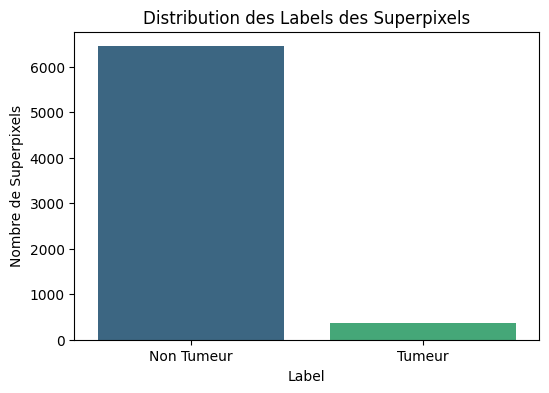

In [95]:
# compter les labels
unique, counts = np.unique(node_labels.numpy(), return_counts=True)
label_counts = dict(zip(unique, counts))

plt.figure(figsize=(6,4))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette='viridis')
plt.xlabel('Label')
plt.ylabel('Nombre de Superpixels')
plt.title('Distribution des Labels des Superpixels')
plt.xticks([0,1], ['Non Tumeur', 'Tumeur'])
plt.show()

attention au biais d'interpretation, avoir plus de superpixels tumeurs n'est pas forcément un déséquilibre mais une optimisation qui réduit les superpixels sur le background par exemple 

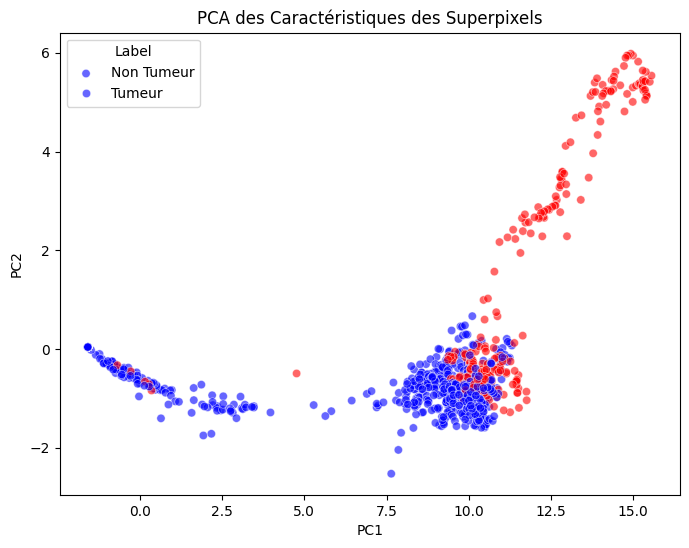

In [97]:
features_np = features.numpy()
labels_np = node_labels.numpy()

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_np)

plt.figure(figsize=(8,6))
sns.scatterplot(x=features_pca[:,0], y=features_pca[:,1], hue=labels_np, palette=['blue', 'red'], alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA des Caractéristiques des Superpixels')
plt.legend(title='Label', labels=['Non Tumeur', 'Tumeur'])
plt.show()

/Users/romain/miniforge3/envs/gat_segmentation/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


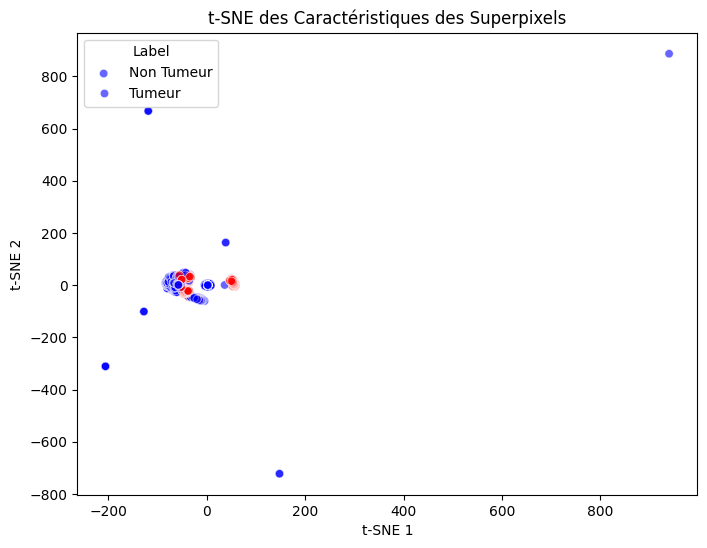

In [98]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=3000)
features_tsne = tsne.fit_transform(features_np)

plt.figure(figsize=(8,6))
sns.scatterplot(x=features_tsne[:,0], y=features_tsne[:,1], hue=labels_np, palette=['blue', 'red'], alpha=0.6)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE des Caractéristiques des Superpixels')
plt.legend(title='Label', labels=['Non Tumeur', 'Tumeur'])
plt.show()

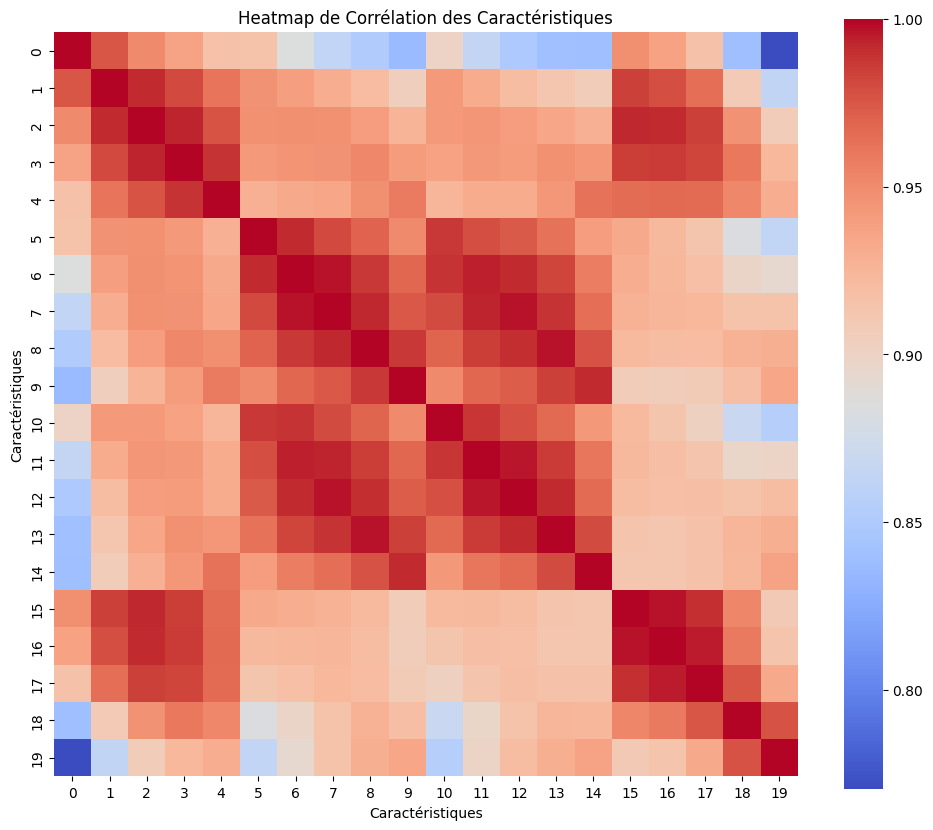

In [99]:
corr_matrix = np.corrcoef(features_np, rowvar=False)

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True, cbar=True)
plt.title('Heatmap de Corrélation des Caractéristiques')
plt.xlabel('Caractéristiques')
plt.ylabel('Caractéristiques')
plt.show()

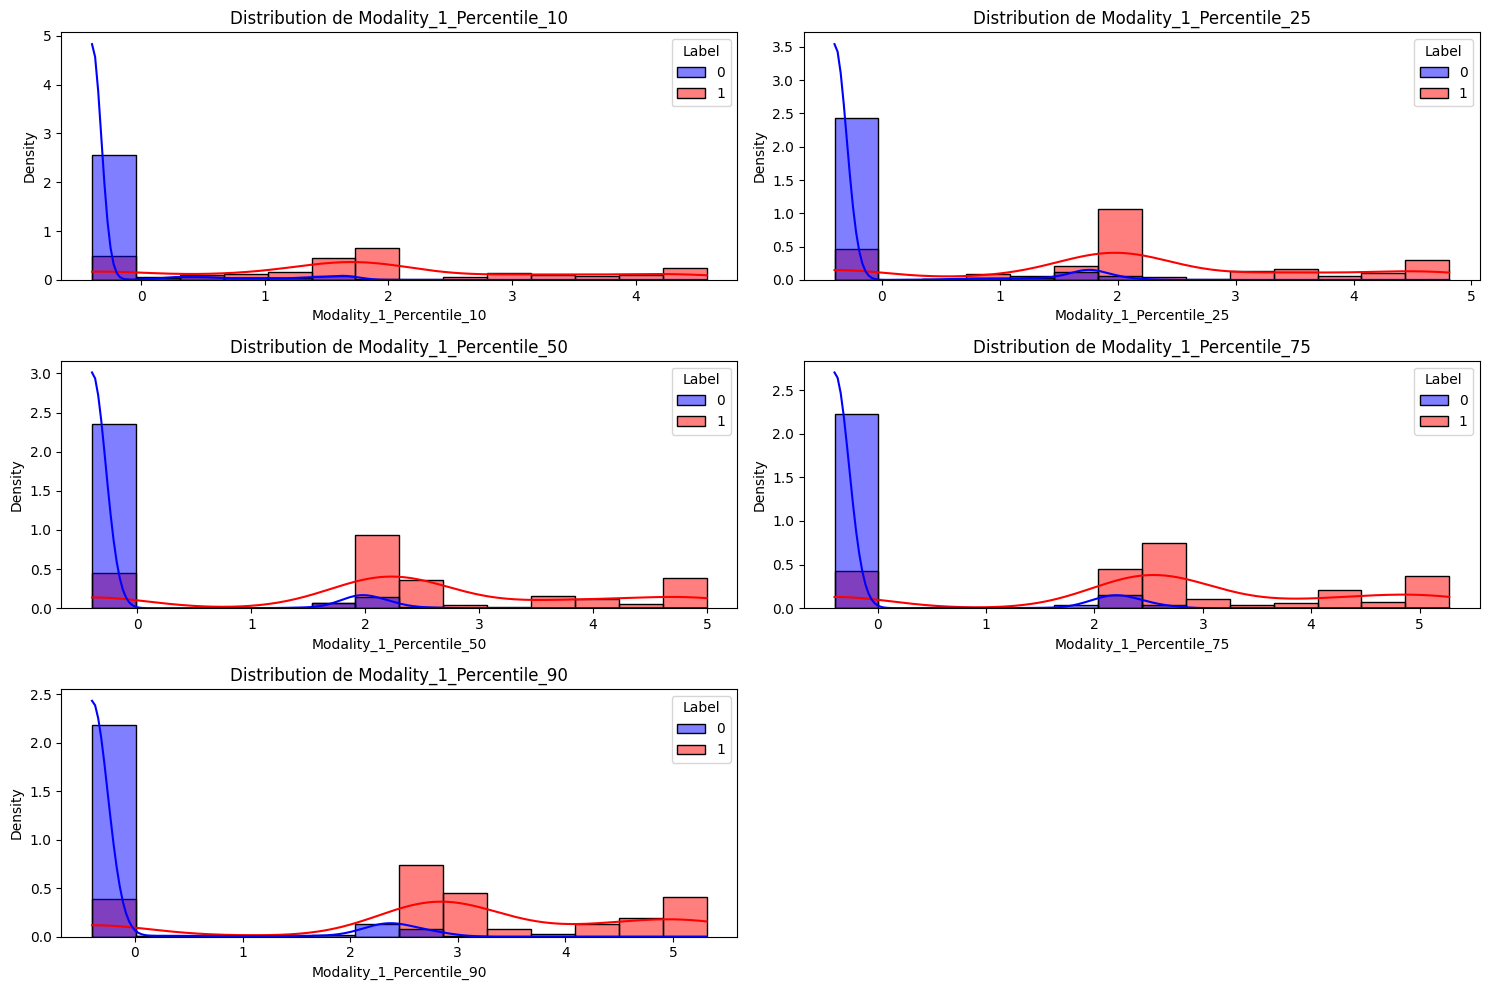

In [100]:
feature_names = [f"Modality_{c}_Percentile_{p}" for c in range(1, 5) for p in [10, 25, 50, 75, 90]]
df = pd.DataFrame(features_np, columns=feature_names)
df['Label'] = labels_np

# quelques caractéristiques pour l'histogramme
selected_features = feature_names[:5]  # Par exemple, les 5 premières

plt.figure(figsize=(15,10))
for i, feature in enumerate(selected_features):
    plt.subplot(3, 2, i+1)
    sns.histplot(data=df, x=feature, hue='Label', kde=True, stat="density", common_norm=False, palette=['blue', 'red'])
    plt.title(f"Distribution de {feature}")
plt.tight_layout()
plt.show()

In [111]:
def construct_graph(superpixels, features, labels):
    """
    Construit un graphe à partir des superpixels, des caractéristiques et des labels.

    Args:
        superpixels (numpy.ndarray): Superpixels 3D de forme (H, W, D).
        features (torch.Tensor): Caractéristiques des nœuds, de forme (num_nodes, num_features).
        labels (torch.Tensor): Labels des nœuds, de forme (num_nodes,).

    Returns:
        Data: Graphe PyTorch Geometric contenant les nœuds, arêtes et données associées.
    """
    try:
        H, W, D = superpixels.shape
        num_nodes = len(features)

        print(f"Dimensions des superpixels: (H={H}, W={W}, D={D})")
        print(f"Nombre de nœuds/features: {num_nodes}")

        edge_index = []
        
        # cv map chaque superpixel à un noeud
        unique_superpixels = np.unique(superpixels)
        sp_to_node = {sp: i for i, sp in enumerate(unique_superpixels)}
        print(f"Nombre de superpixels uniques: {len(unique_superpixels)}")
        
        # créer mtn les aretes en connectant les superpixels adjacents
        print("Construction des arêtes...")
        for z in range(D):
            for y in range(H):
                for x in range(W):
                    current_sp = superpixels[y, x, z]
                    if current_sp not in sp_to_node:
                        continue
                    
                    current_node = sp_to_node[current_sp]
                    neighbors = [
                        (y + dy, x + dx, z + dz)
                        for dy, dx, dz in [(-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]
                        if 0 <= y + dy < H and 0 <= x + dx < W and 0 <= z + dz < D
                    ]
                    
                    for ny, nx, nz in neighbors:
                        neighbor_sp = superpixels[ny, nx, nz]
                        if neighbor_sp in sp_to_node:
                            neighbor_node = sp_to_node[neighbor_sp]
                            edge_index.append((current_node, neighbor_node))
        
        print(f"Nombre total d'arêtes avant suppression des doublons: {len(edge_index)}")
        
        # important -> supprimer les doublons dans les arêtes
        edge_index_set = list(set(edge_index))
        print(f"Nombre total d'arêtes après suppression des doublons: {len(edge_index_set)}")
        
        # convertir les arêtes en tensor
        if len(edge_index_set) == 0:
            raise ValueError("Aucune arête trouvée après suppression des doublons.")
        
        edge_index_tensor = torch.tensor(edge_index_set, dtype=torch.long).T
        print(f"Dimensions de edge_index: {edge_index_tensor.shape}")
        
        # verif les dimensions des données d'entrée
        if features.shape[0] != num_nodes:
            raise ValueError(f"Mismatch: nombre de features ({features.shape[0]}) différent de num_nodes ({num_nodes}).")
        if labels.shape[0] != num_nodes:
            raise ValueError(f"Mismatch: nombre de labels ({labels.shape[0]}) différent de num_nodes ({num_nodes}).")

        # build le graphe
        graph = Data(
            x=features,           # cractéristiques des noeuds
            edge_index=edge_index_tensor, # Arêtes
            y=labels               # Labels des noeuds
        )
        
        print("Graphe construit avec succès!")
        return graph

    except Exception as e:
        print(f"Erreur dans construct_graph: {e}")
        raise

try:
    graph = construct_graph(superpixels, features, node_labels)
    print(graph)
except Exception as e:
    print(f"Erreur lors de la construction du graphe: {e}")

Dimensions des superpixels: (H=240, W=240, D=155)
Nombre de nœuds/features: 6754
Nombre de superpixels uniques: 6754
Construction des arêtes...
Nombre total d'arêtes avant suppression des doublons: 53304000
Nombre total d'arêtes après suppression des doublons: 75176
Dimensions de edge_index: torch.Size([2, 75176])
Graphe construit avec succès!
Data(x=[6754, 20], edge_index=[2, 75176], y=[6754])


quand on créer le graphe, on peut créer des doublons par mégarde vu que c'est exploratoire

In [112]:
print("Nombre de nœuds :", graph.num_nodes)
print("Nombre d'arêtes :", graph.num_edges)
print("Nombre de caractéristiques par nœud :", graph.num_node_features)
print("Nombre de classes dans les labels :", graph.y.unique().size(0))
from torch_geometric.utils import is_undirected, contains_self_loops

print("Le graphe est non orienté :", is_undirected(graph.edge_index))
print("Le graphe contient des boucles :", contains_self_loops(graph.edge_index))

Nombre de nœuds : 6754
Nombre d'arêtes : 75176
Nombre de caractéristiques par nœud : 20
Nombre de classes dans les labels : 2
Le graphe est non orienté : True
Le graphe contient des boucles : True


In [113]:
from torch_geometric.utils import degree

degrees = degree(graph.edge_index[0], num_nodes=graph.num_nodes)
print("Degré minimum :", degrees.min().item())
print("Degré maximum :", degrees.max().item())
print("Degré moyen :", degrees.mean().item())

Degré minimum : 4.0
Degré maximum : 32.0
Degré moyen : 11.130589485168457


In [114]:
from collections import Counter

label_counts = Counter(graph.y.tolist())
print("Répartition des labels :", label_counts)

Répartition des labels : Counter({0: 6689, 1: 65})


In [115]:
mean_features = graph.x.mean(dim=0)
std_features = graph.x.std(dim=0)
print("Moyenne des caractéristiques par nœud :", mean_features)
print("Écart-type des caractéristiques par nœud :", std_features)

Moyenne des caractéristiques par nœud : tensor([-0.1571, -0.1022, -0.0661, -0.0327,  0.0028, -0.1433, -0.1056, -0.0733,
        -0.0379, -0.0049, -0.1304, -0.1029, -0.0797, -0.0497, -0.0118, -0.1641,
        -0.1387, -0.1000, -0.0269,  0.0792])
Écart-type des caractéristiques par nœud : tensor([0.7174, 0.8468, 0.9343, 1.0014, 1.0607, 0.7498, 0.8462, 0.9287, 1.0005,
        1.0504, 0.7864, 0.8554, 0.9144, 0.9718, 1.0354, 0.6527, 0.7190, 0.8225,
        0.9994, 1.2416])


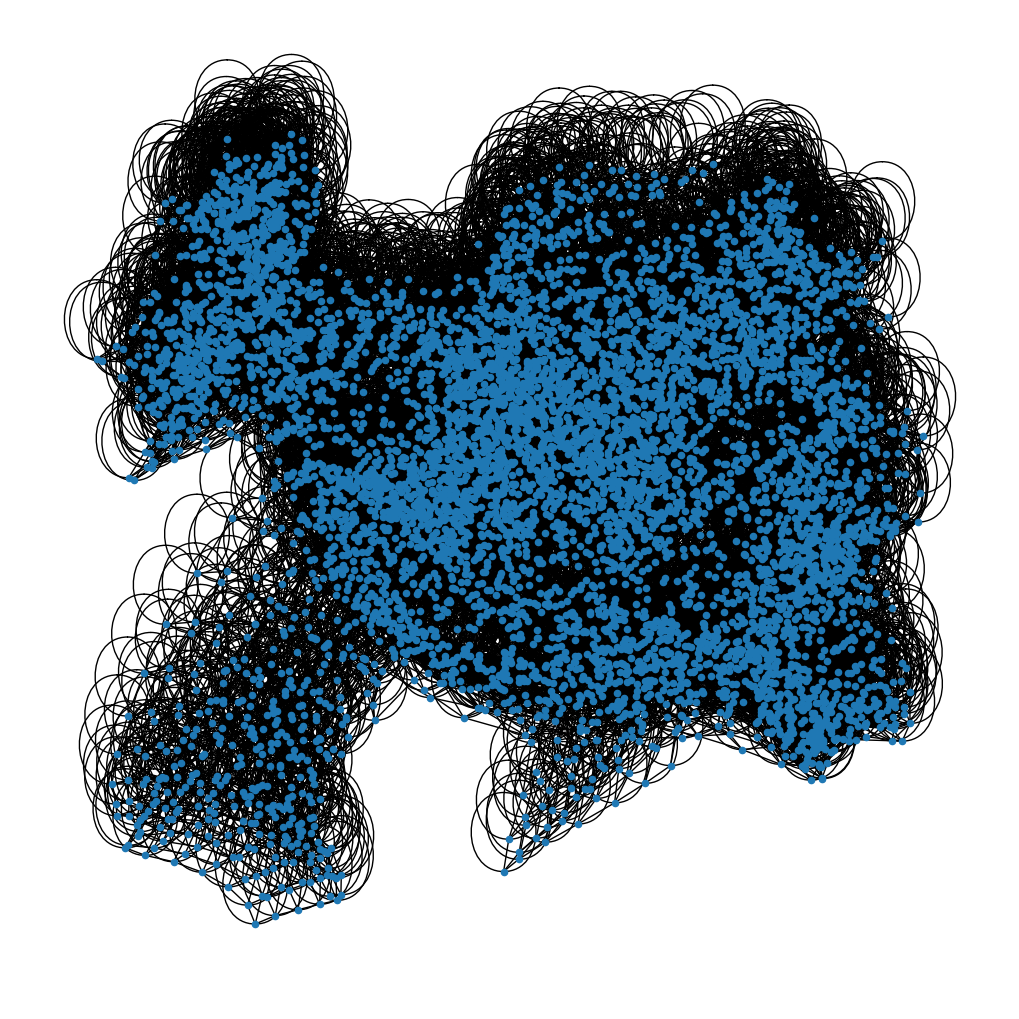

In [116]:
nx_graph = to_networkx(graph, to_undirected=True)

plt.figure(figsize=(10, 10))
nx.draw(nx_graph, with_labels=False, node_size=20)
plt.show()

funfact, j'ai pris 7h à charger le dataset en graphes sans les optimis / compromis

In [31]:
class BraTSGraphDataset(Dataset):
    def __init__(
        self,
        data_root,
        case_names,
        slic_n_segments=50,
        slic_compactness=0.1,
        slic_sigma=0.1,
        percentiles=[10, 25, 50, 75, 90],
        use_bounding_box=True,
        reduce_supervoxels_factor=1,
        transform=None
    ):
        """
        dataset qui, pour chaque cas, produit un graphe pyg (data).

        args:
          data_root (str): répertoire où se trouvent les dossiers patient.
          case_names (list): liste des noms (ID) de cas/patients (ex: "BraTS2021_00001", etc.).
          slic_n_segments (int): nb de segments par coupe (SLIC 3d slice-by-slice).
          slic_compactness (float): param slic.
          slic_sigma (float): param slic.
          percentiles (list of int): liste des percentiles pour l'extraction de features.
          use_bounding_box (bool): si vrai, on rogne la zone tumeur avant de construire le graphe.
          reduce_supervoxels_factor (int): facteur de fusion d'id superpixels (astuce).
          transform (callable): éventuellement un compose de transformations monai / torchvision, etc.
        """
        super().__init__()
        self.data_root = data_root
        self.case_names = case_names
        self.transform = transform

        self.slic_n_segments = slic_n_segments
        self.slic_compactness = slic_compactness
        self.slic_sigma = slic_sigma
        self.percentiles = percentiles
        self.use_bounding_box = use_bounding_box
        self.reduce_supervoxels_factor = reduce_supervoxels_factor

    def __len__(self):
        return len(self.case_names)
    
    def __getitem__(self, idx):
        """
        charge un cas, construit et renvoie le graphe pyg (data).
        """
        case_id = self.case_names[idx]
        base_dir = os.path.join(self.data_root, case_id, case_id)

        flair_path = base_dir + '_flair.nii.gz'
        t1_path    = base_dir + '_t1.nii.gz'
        t1ce_path  = base_dir + '_t1ce.nii.gz'
        t2_path    = base_dir + '_t2.nii.gz'
        seg_path   = base_dir + '_seg.nii.gz'

        flair = nib.load(flair_path).get_fdata()
        t1    = nib.load(t1_path).get_fdata()
        t1ce  = nib.load(t1ce_path).get_fdata()
        t2    = nib.load(t2_path).get_fdata()
        seg   = nib.load(seg_path).get_fdata()

        # empilement => (H, W, D, C=4)
        image = np.stack([flair, t1, t1ce, t2], axis=-1)
        
        # -> transform type monai (ToTensor, NormalizeRobust, etc.)
        if self.transform is not None:
            sample = {'image': image, 'label': seg}
            sample = self.transform(sample)
            image = sample['image'].numpy()  # (C, H, W, D)
            seg   = sample['label'].numpy()  # (H, W, D)
        else:
            # si pas de transform, faire un reorder:
            # (H, W, D, C) -> (C, H, W, D)
            image = image.transpose(3,0,1,2)  # (4, H, W, D)
            seg = seg.astype(np.int64)        # (H, W, D)

        # appliquer SLIC 3D (ou la version "slice-by-slice")
        superpixels = apply_slic_3d(
            image,
            n_segments=self.slic_n_segments,
            compactness=self.slic_compactness,
            sigma=self.slic_sigma
        )

        # extraire features => (num_nodes, num_features), (num_nodes,)
        features, labels = extract_node_features_parallel(
            images=image,
            superpixels=superpixels,
            mask=seg,
            percentiles=self.percentiles,
            use_bounding_box=self.use_bounding_box,
            reduce_supervoxels_factor=self.reduce_supervoxels_factor,
            n_jobs=-1,
            batch_size=50
        )

        # construire le graphe => Data
        # attention: si extract_node_features_parallel rogne superpixels, 
        # tu dois lui récupérer la version rognée => renvoie-la ? 
        # ou alors tu rogne manuellement avant apply_slic_3d => adapt...
        # pour l'exemple, on suppose qu'il rogne 
        # et qu'on doit le faire APRES superpixels

        # si extract_node_features_parallel rogne l'image, 
        # superpixels est rogné => on doit re-récupérer ce superpixels rogné.
        # Ex: 
        # superpixels_crop = la version rognée renvoyée par la fonction (ou soigner l'ordre).
        # graph = construct_graph(superpixels_crop, features, labels)

        # si on reste simple, on rogne AVANT SLIC => 
        # (ex: bounding box sur image et seg, PUIS SLIC).
        # => je montre juste la version "direct" ci-dessous:
        graph = construct_graph(superpixels, features, labels)

        return graph

In [32]:
train_graph_dataset = BraTSGraphDataset(
    data_root=data_root,
    case_names=train_cases,
    slic_n_segments=50,
    slic_compactness=0.1,
    slic_sigma=0.1,
    transform=transforms.Compose([
        ToTensor(),
        NormalizeRobust()
    ])
)

train_graph_loader = PyGDataLoader(train_graph_dataset, batch_size=2, shuffle=True)

batch = next(iter(train_graph_loader))
print(batch)  

coupe 0 terminée en 0.02 secondes
coupe 1 terminée en 0.01 secondes
coupe 2 terminée en 0.01 secondes
coupe 3 terminée en 0.01 secondes
coupe 4 terminée en 0.01 secondes
coupe 5 terminée en 0.01 secondes
coupe 6 terminée en 0.01 secondes
coupe 7 terminée en 0.01 secondes
coupe 8 terminée en 0.01 secondes
coupe 9 terminée en 0.01 secondes
coupe 10 terminée en 0.01 secondes
coupe 11 terminée en 0.01 secondes
coupe 12 terminée en 0.01 secondes
coupe 13 terminée en 0.01 secondes
coupe 14 terminée en 0.01 secondes
coupe 15 terminée en 0.01 secondes
coupe 16 terminée en 0.01 secondes
coupe 17 terminée en 0.01 secondes
coupe 18 terminée en 0.02 secondes
coupe 19 terminée en 0.01 secondes
coupe 20 terminée en 0.01 secondes
coupe 21 terminée en 0.01 secondes
coupe 22 terminée en 0.01 secondes
coupe 23 terminée en 0.01 secondes
coupe 24 terminée en 0.01 secondes
coupe 25 terminée en 0.01 secondes
coupe 26 terminée en 0.01 secondes
coupe 27 terminée en 0.01 secondes
coupe 28 terminée en 0.01 seco

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:    1.4s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    1.5s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:    1.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:    1.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    1.8s finished


temps pour la partie parallelisation (batch) : 1.88s
temps concaténation des batchs: 0.00s
temps pour filtrer les résultats invalides: 0.00s
temps pour créer les tenseurs pytorch: 0.00s
temps total pour extract_node_features_parallel optimisé: 1.97s
Dimensions des superpixels: (H=240, W=240, D=155)
Nombre de nœuds/features: 662
Nombre de superpixels uniques: 6892
Construction des arêtes...
Nombre total d'arêtes avant suppression des doublons: 53304000
Nombre total d'arêtes après suppression des doublons: 83528
Dimensions de edge_index: torch.Size([2, 83528])
Graphe construit avec succès!
coupe 0 terminée en 0.02 secondes
coupe 1 terminée en 0.01 secondes
coupe 2 terminée en 0.01 secondes
coupe 3 terminée en 0.01 secondes
coupe 4 terminée en 0.01 secondes
coupe 5 terminée en 0.01 secondes
coupe 6 terminée en 0.01 secondes
coupe 7 terminée en 0.01 secondes
coupe 8 terminée en 0.01 secondes
coupe 9 terminée en 0.01 secondes
coupe 10 terminée en 0.01 secondes
coupe 11 terminée en 0.01 seco

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16660475730895996s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  22 | elapsed:    0.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  13 out of  22 | elapsed:    1.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  16 out of  22 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  19 out of  22 | elapsed:    1.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.8s finished


temps pour la partie parallelisation (batch) : 1.95s
temps concaténation des batchs: 0.00s
temps pour filtrer les résultats invalides: 0.00s
temps pour créer les tenseurs pytorch: 0.00s
temps total pour extract_node_features_parallel optimisé: 2.10s
Dimensions des superpixels: (H=240, W=240, D=155)
Nombre de nœuds/features: 1066
Nombre de superpixels uniques: 6980
Construction des arêtes...
Nombre total d'arêtes avant suppression des doublons: 53304000
Nombre total d'arêtes après suppression des doublons: 83554
Dimensions de edge_index: torch.Size([2, 83554])
Graphe construit avec succès!
DataBatch(x=[1728, 20], edge_index=[2, 167082], y=[1728], batch=[1728], ptr=[3])


## Model

In [36]:
class BrainGAT(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, 
                 num_heads=4, negative_slope=0.2, dropout=0.0):
        """
        Args:
          in_features (int): dimension des features d'entrée (f).
          hidden_features (int): dimension cachée.
          out_features (int): dimension de sortie (C classes).
          num_heads (int): nombre de têtes d'attention multi-head pour la 1ere couche.
          negative_slope (float): slope pour LeakyReLU.
          dropout (float): dropout dans GATConv.
        """
        super().__init__()
        # Première couche GAT : multi-head => dimension de sortie = hidden_features * num_heads (concat=True)
        self.gat1 = GATConv(
            in_channels=in_features, 
            out_channels=hidden_features, 
            heads=num_heads, 
            negative_slope=negative_slope,
            dropout=dropout,
            concat=True
        )
        # Deuxième couche GAT : 1 seul head => dimension de sortie = out_features (concat=False)
        self.gat2 = GATConv(
            in_channels=hidden_features * num_heads, 
            out_channels=out_features,
            heads=1,
            negative_slope=negative_slope,
            dropout=dropout,
            concat=False
        )
        
    def forward(self, x, edge_index):
        """
        x: [num_nodes, in_features]
        edge_index: [2, num_edges]
        """
        # 1) première couche GAT
        x = self.gat1(x, edge_index)  
        x = F.leaky_relu(x, negative_slope=0.2)  # ou elu, ou gelu
        # 2) deuxième couche GAT
        x = self.gat2(x, edge_index)
        return x

## Training 

In [37]:
# pour rappel, suppose qu'on ait déjà : 
# - train_graph_dataset, val_graph_dataset
# - BrainGAT (défini ci-dessus) 
# - un device (e.g. "cuda" ou "cpu") (config recommandée : AMD Ryzen 7 4800HS 2.90 GHz with a Tesla K80 GPU having 2496 CUDA cores and 35 GB of DDR5 VRAM)

def train_gat_model(
    train_dataset, 
    val_dataset,
    in_features,
    hidden_features,
    out_features,
    num_heads=4,
    negative_slope=0.2,
    dropout=0.0,
    lr=1e-3,
    weight_decay=1e-4,
    gamma=0.9999,  # pour la décroissance exponentielle (ex: ~0.0001 de rate total sur 300 epochs)
    max_epochs=300,
    batch_size=6,
    checkpoint_dir="checkpoints",
    log_dir="runs/gat_brain_seg"
):
    """
    Entraîne un GAT pour la segmentation de tumeur.
    Args:
      train_dataset (Dataset): dataset PyG (ou custom) pour l'entraînement.
      val_dataset   (Dataset): dataset PyG pour la validation.
      in_features (int): dimension d'entrée.
      hidden_features (int): dimension cachée.
      out_features (int): nb de classes en sortie (ex: 2 ou 3 ou 4).
      num_heads (int): nb têtes multi-head (1ere couche).
      negative_slope (float): slope leaky relu.
      dropout (float): dropout dans GATConv.
      lr (float): learning rate initial.
      weight_decay (float): L2 régularisation.
      gamma (float): param pour ExponentialLR => lr_new = lr_old * gamma
      max_epochs (int): nb d'époques d'entraînement (300).
      batch_size (int): taille de lot (de graphes).
      checkpoint_dir (str): dossier où sauvegarder les checkpoints.
      log_dir (str): dossier où stocker les logs tensorboard.
    """

    if torch.backends.mps.is_available():
        device = torch.device("mps") 
    elif torch.cuda.is_available():
        device = torch.device("cuda") 
    else:
        device = torch.device("cpu")

    print(f"Training on device: {device}")

    # dataloader
    train_loader = PyGDataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = PyGDataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # notre modèle GAT
    model = BrainGAT(
        in_features=in_features,
        hidden_features=hidden_features,
        out_features=out_features,
        num_heads=num_heads,
        negative_slope=negative_slope,
        dropout=dropout
    )
    model.to(device)

    # Adam + scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # Scheduler exponentiel
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    # Critère de perte : cross entropy
    # si multi-classes => labels: shape [num_nodes], 0..C-1
    # si multi-label => BCEWithLogitsLoss (à adapter)
    criterion = nn.CrossEntropyLoss()

    # tensorboard
    writer = SummaryWriter(log_dir=log_dir)

    # checkpointing
    os.makedirs(checkpoint_dir, exist_ok=True)
    best_val_loss = float("inf")
    global_step = 0

    for epoch in range(1, max_epochs+1):
        ### Entraînement ###
        model.train()
        running_loss = 0.0
        for batch_data in train_loader:
            batch_data = batch_data.to(device)
            # batch_data.x : [NbNoeudsTotaleDuBatch, in_features]
            # batch_data.y : [NbNoeudsTotaleDuBatch] (ou shape similaire)
            # batch_data.edge_index : [2, NbAretesTotaleDuBatch]
            optimizer.zero_grad()
            
            logits = model(batch_data.x, batch_data.edge_index)  # [total_nodes_in_batch, out_features]

            # calcul de la perte
            # attention: si multi-classe, batch_data.y doit être des entiers
            loss = criterion(logits, batch_data.y)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            writer.add_scalar("Loss/train_step", loss.item(), global_step)
            global_step += 1

        # moyenne de la loss sur l'epoch
        train_loss_epoch = running_loss / len(train_loader)
        
        ### Validation ###
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_data in val_loader:
                batch_data = batch_data.to(device)
                logits = model(batch_data.x, batch_data.edge_index)
                loss = criterion(logits, batch_data.y)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # scheduler step (décroît le lr)
        lr_scheduler.step()

        # logs epoch
        writer.add_scalar("Loss/train", train_loss_epoch, epoch)
        writer.add_scalar("Loss/val", val_loss, epoch)
        current_lr = optimizer.param_groups[0]['lr']
        writer.add_scalar("LearningRate", current_lr, epoch)

        print(f"[Epoch {epoch:03d}] train_loss={train_loss_epoch:.4f} val_loss={val_loss:.4f} lr={current_lr:.6f}")

        # checkpoint si meilleure val_loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_path = os.path.join(checkpoint_dir, f"best_model_epoch_{epoch}.pt")
            torch.save(model.state_dict(), save_path)
            print(f"  -> Best val loss improved; model saved to {save_path}")

    writer.close()
    print("Training finished.")

    return model  # retourne le dernier modèle (on a aussi checkpointé le meilleur)

In [ ]:
model = train_gat_model(
    train_dataset=train_graph_dataset,
    val_dataset=val_graph_dataset,
    in_features=20,        # ex: 4 canaux × 5 percentiles
    hidden_features=32,    # dimension cachée (à ajuster)
    out_features=2,        # tumeur / non-tumeur (ou 3 classes)
    num_heads=4,
    negative_slope=0.2,
    dropout=0.1,           # si tu veux du dropout
    lr=1e-3,
    weight_decay=1e-4,
    gamma=0.9999,          # decay exponentiel
    max_epochs=300,
    batch_size=6,
    checkpoint_dir="checkpoints_gat",
    log_dir="runs/gat_brain_seg"
)